In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Images and their segmented versions should be in `Segmented_dataset` folder and have names `original_k.jpg` and `segmented_k.jpg` for some natural $k$.

**Load the the images:**

In [948]:
k = 6
ORIG_PATH = 'Segmented_dataset/original_' +str(k) + '.jpg'
SEG_PATH = 'Segmented_dataset/segmented_' +str(k) + '.jpg'

In [949]:
img = cv2.imread(ORIG_PATH, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

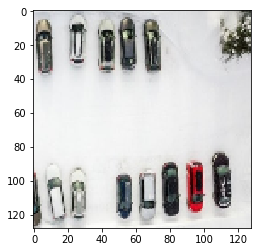

In [950]:
plt.imshow(img)

In [951]:
seg = cv2.imread(SEG_PATH, cv2.IMREAD_COLOR)
seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

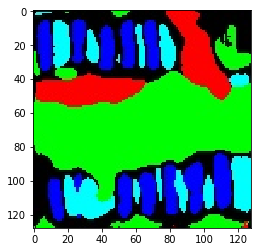

In [952]:
plt.imshow(seg)

**Consider only 'cars' label mask from segmented image:**

In [953]:
cars = seg.copy()
for i in range(128):
    for j in range(128):
        if cars[i][j][0] > 50:
            cars[i][j][0] = 0
            cars[i][j][1] = 0
            cars[i][j][2] = 0
            #cars[i][j] = [0, 0, 0]
        elif cars[i, j, 1] > 50:
            cars[i][j][0] = 0
            cars[i][j][1] = 0
            cars[i][j][2] = 0
            #cars[i][j] = [0, 0, 0]
cars = cv2.cvtColor(cars, cv2.COLOR_BGR2GRAY)

In [954]:
_, th = cv2.threshold(cars,50,255,cv2.THRESH_BINARY)

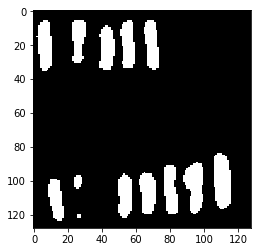

In [955]:
plt.imshow(th, cmap='gray')

**To remove outliers apply opening and closing:**

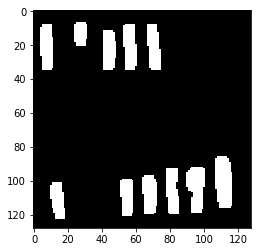

In [956]:
mask_int = th.astype(np.uint8)
kernel = np.ones((6,6))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
kernel = np.ones((1,1))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
#img2 = img.copy()
#img2[mask_int == 1] = 0

plt.imshow(mask_int, cmap='gray')

In [957]:
mask_inv = 255-mask_int
contours, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_cnt = img.copy()
for i in range(len(contours)):
    if hierarchy[0][i][-1] < 0:
        continue #outermost contour
    elif hierarchy[0][i][-1] == 0:
        #main objects
        color = (0,0,0)
    elif hierarchy[0][i][-1] > 0:
        #inner holes
        color = (255,255,255)
    cv2.drawContours(img_cnt, contours, i, color, 1)
pass

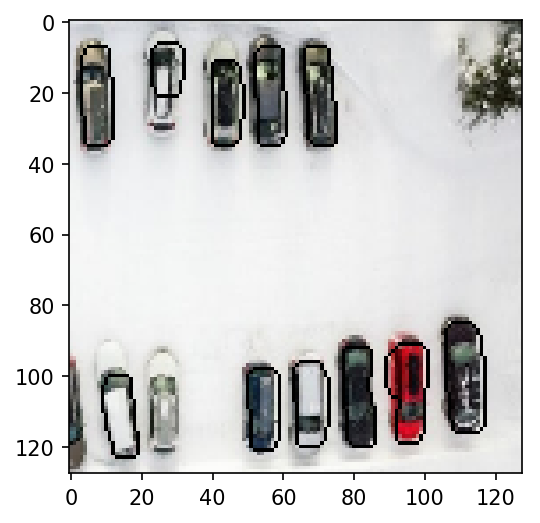

In [959]:
plt.figure(dpi=150)
plt.imshow(img_cnt)

**Build bounding rectangulars for cars:**

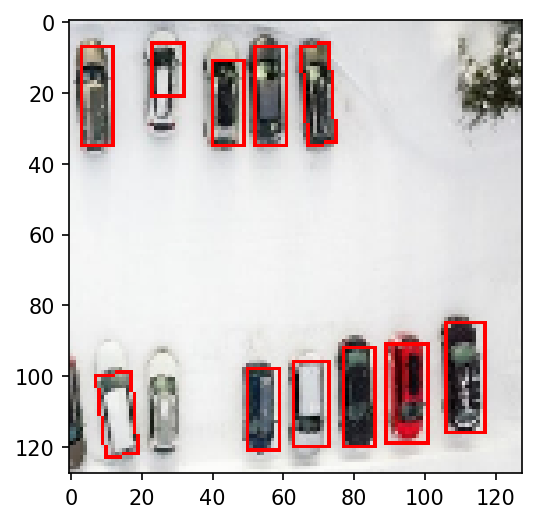

In [960]:
img_cnt = img.copy()
boxes = []
for i in range(len(contours)):
    if hierarchy[0][i][-1] != 0:
        continue
    if cv2.contourArea(contours[i]) < 20:
        continue
    
    rect = cv2.minAreaRect(contours[i])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    boxes.append(box)
    cv2.drawContours(img_cnt,[box], 0, (255,0,0), 1)
    
plt.figure(dpi=150)
plt.imshow(img_cnt)

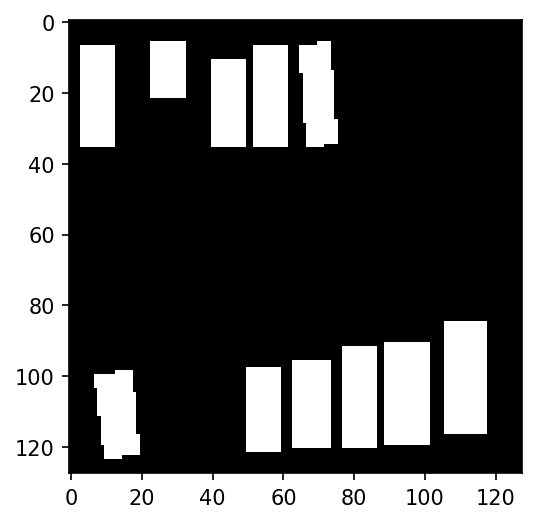

In [961]:
rects = np.zeros((128, 128))
for i in range(len(contours)):
    if hierarchy[0][i][-1] != 0:
        continue
    if cv2.contourArea(contours[i]) < 20:
        continue
    
    rect = cv2.minAreaRect(contours[i])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    boxes.append(box)
    cv2.drawContours(rects, [box], 0, (255,255,255), -1)
    
plt.figure(dpi=150)
plt.imshow(rects, cmap='gray')

**Implement the final algorithm:**

In [966]:
def get_ortho(box):
    # find the center point of rectangular
    img_cnt = img.copy()
    center = box.mean(axis=0)
    a = box[0] - box[1]
    b = box[1] - box[2]
    # c will be a vector that is orthogonal to car's direction and has length equals to width of the car 
    if np.linalg.norm(a) > np.linalg.norm(b):
        c = b
    else:
        c = a
    dots = []
    free_spaces = []
    cur_free_spaces = []
    
    # the function that check whether a point is out of the image
    def is_in(point):
        return ~((point[0] < 0) or (point[0] > 127) or (point[1] < 0) or (point[1] > 127))
    
    dot = np.copy(center)
    while is_in(dot):
        if rects[int(dot[1])][int(dot[0])] == 0:
            cur_free_spaces.append(np.copy(dot))
        else:
            free_spaces.extend(cur_free_spaces)
            cur_free_spaces = []
        dots.append(np.copy(dot))
        dot += 1.34*c 
        
    cur_free_spaces = []
    dot = np.copy(center)
    while is_in(dot):
        if rects[int(dot[1])][int(dot[0])] == 0:
            cur_free_spaces.append(np.copy(dot))
        else:
            free_spaces.extend(cur_free_spaces)
            cur_free_spaces = []
        dots.append(np.copy(dot))
        dot -= 1.35*c 
    
    for dot in dots:
        img_cnt = cv2.circle(img_cnt, (int(dot[0]), int(dot[1])), 3, (255, 255, 0), 1)
    for space in free_spaces:
        img_cnt = cv2.circle(img_cnt, (int(space[0]), int(space[1])), 3, (0, 255, 0), -1)
    plt.figure(dpi=150)
    plt.imshow(img_cnt)
    return center

In [967]:
j = 0
for i in range(1, len(boxes)):
    #if cv2.arcLength(boxes[i],True) > cv2.arcLength(boxes[j],True):
    if cv2.contourArea(boxes[i]) > cv2.contourArea(boxes[j]):
        j = i
if k == 2:
    j = 8
elif k == 6:
    j = 0
elif k == 1:
    j = 3
elif k == 3:
    j = 7


**Les us see the result**

array([ 13.25, 111.  ])

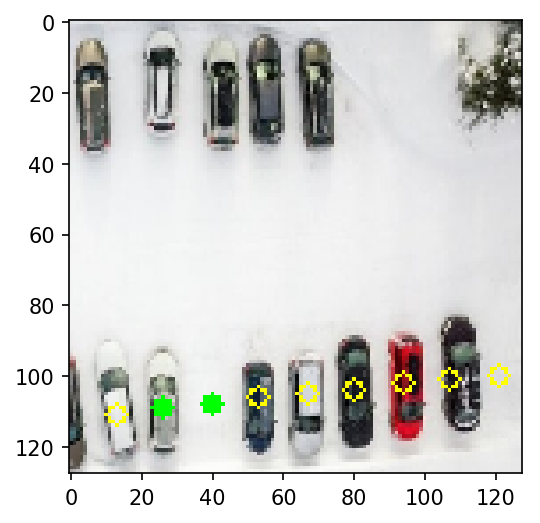

In [968]:
get_ortho(boxes[j])